In [1]:
# import package
from tqdm import tqdm
import numpy as np
import random
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import string
from torch.utils.data import Dataset, DataLoader
import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
nltk.download('stopwords')
nltk.download("wordnet")
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
import pandas as pd
# load
combined_df = pd.read_csv('combined_df.csv',on_bad_lines='skip')
print(combined_df.shape)

(160152, 2)


Text(0.5, 1.0, 'Data Distribution')

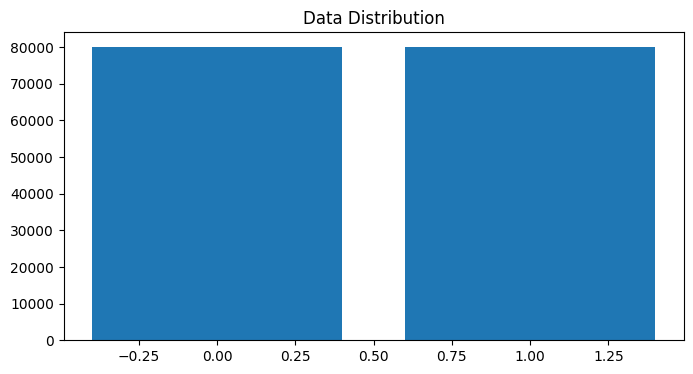

In [3]:
import matplotlib.pyplot as plt
val_count = combined_df.label.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Data Distribution")

In [4]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(combined_df, test_size=0.2)

In [5]:
# setting seed
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    return seed

seed_everything(42)
MAX_LENGTH = 30
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [6]:
# data cleaning
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r' ', string)

def clean_sentence(sentence):
    # remove URLS
    sentence = re.sub(r'http\S+', ' ', sentence)
    # remove emoji's
    sentence = remove_emoji(sentence)
    # remove punctuation
    sentence = re.sub("[^0-9A-Za-z ]", "" , sentence)
    # remove double spaces
    sentence = sentence.replace('  ',"")

    return sentence.strip()

def remove_stopwords(tokens, stopwords):
    clean_token = [word for word in tokens if word not in stopwords]
    return clean_token

# lemmalization
def lemmatize(tokens, lemma):
    lemmatized_tokens = [lemma.lemmatize(token, pos = 'v') for token in tokens]
    return lemmatized_tokens

In [7]:
# fix sentence length
def trunc_padding(sentence):
    modify_sentence = sentence.copy()
    if len(modify_sentence) >= MAX_LENGTH:
        modify_sentence = modify_sentence[:MAX_LENGTH]
    else:
        modify_sentence.extend(list(["0"] * (MAX_LENGTH - len(modify_sentence))))
    return modify_sentence

In [8]:
# processing data cleaning
stopwords = nltk.corpus.stopwords.words('english')
lemma = WordNetLemmatizer()

def processing(df, stopwords, lemma):
    df['text'] = df['text'].apply(lambda sentence: sentence.lower())
    df['text'] = df['text'].apply(lambda sentence: clean_sentence(sentence))
    # tokenization
    df['text'] = df['text'].apply(lambda sentence: sentence.split())
    # # remove stopwords
    # df['text'] = df['text'].apply(lambda sentence: remove_stopwords(sentence, stopwords))
    # # lemmalization
    # df['text'] = df['text'].apply(lambda sentence: lemmatize(sentence, lemma))
    # sentence length before padding
    df['length'] = df['text'].apply(lambda x: len(x))
    # fix sentence length
    df['text'] = df['text'].apply(lambda sentence: trunc_padding(sentence))
    # sentence length after padding
    df['length_padding'] = df['text'].apply(lambda x: len(x))

processing(train, stopwords, lemma)
processing(test, stopwords, lemma)

In [9]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [10]:
train.head()

,text,label,length,length_padding
0,"[no, group, has, taken, responsibility, for, f...",0,12,30
1,"[the, clause, has, been, utilized, by, several...",1,36,30
2,"[in, january, deepmind, an, artificial, intell...",1,11,30
3,"[he, mentioned, that, it, takes, a, distance, ...",1,18,30
4,"[it, is, beneath, him, habana, and, others, to...",0,12,30


### Assign unique index to each word, used for word embedding

In [11]:
# get all vocabulary
vocab_list = []
for sentence in train['text']:
    vocab_list.append(sentence)
vocab = build_vocab_from_iterator(vocab_list, specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [12]:
class Dataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        sentence = self.x[idx]
        x = torch.tensor(vocab(sentence), dtype=torch.long).to(device)
        y = torch.tensor(self.y[idx], dtype=torch.long).to(device)
        return x, y

In [13]:
# model configuration
model_config = {
    'vocab_size': len(vocab),
    'hidden_dim' : 256,
    'embedding_dim' : 200,
    'num_classes' : 2,
    'n_layers': 3,
    'dropout': 0.2
}

In [14]:
train_data = Dataset(train['text'], train['label'])
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)

In [15]:
for batch in train_dataloader:
    print(batch)
    break

[tensor([[    6,   764,  1996,  ...,     1,     1,     1],
        [    2,  1460,  4340,  ...,     1,     1,     1],
        [ 3361,  3005,     5,  ...,     1,     1,     1],
        ...,
        [  131,    26,  2941,  ...,     1,     1,     1],
        [   25,  1828, 17260,  ...,    18,   430, 34131],
        [ 2674,    12,  1208,  ...,     1,     1,     1]], device='cuda:0'), tensor([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
        1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
        1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')]


### LSTM MODEL

In [16]:
# LSTM with attention
class LSTM_Attention(nn.Module):
    def __init__(self, config):
        super(LSTM_Attention, self).__init__()
        self.config = config
        self.embedding = nn.Embedding(config['vocab_size'], config['embedding_dim'])
        self.lstm = nn.LSTM(config['embedding_dim'], config['hidden_dim'], bidirectional=True)
        self.fc = nn.Linear(config['hidden_dim'] * 2, config['num_classes'])
        self.sigmoid = nn.Sigmoid()

    def attention(self, lstm_output, final_state):
        hidden = final_state.view(-1, self.config['hidden_dim'] * 2, 1)
        attn_weights = torch.bmm(lstm_output, hidden).squeeze(2)
        soft_attn_weights = F.softmax(attn_weights, 1)
        context = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)
        return context

    def forward(self, X):
        embeds = self.embedding(X).permute(1, 0, 2)
        hidden_state = Variable(torch.zeros(2, len(X), self.config['hidden_dim'])).to(device)
        cell_state = Variable(torch.zeros(2, len(X), self.config['hidden_dim'])).to(device)
        output, (final_hidden_state, final_cell_state) = self.lstm(embeds, (hidden_state, cell_state))
        output = output.permute(1, 0, 2)
        attn_output = self.attention(output, final_hidden_state)
        output = self.fc(attn_output)
        return self.sigmoid(output)



In [17]:
# calculate accuracy
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    prediction = preds.argmax(dim=1)
    correct = (prediction == y).float() #convert into float for division
    acc = correct.sum() / len(correct)
    return acc

### Training

In [18]:
# make prediction
model = LSTM_Attention(model_config)
model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

In [19]:
device

device(type='cuda', index=0)

In [20]:
# training model
epoch_loss = 0
epoch_acc = 0
for epoch in range(30):
    model.train()
    optimizer.zero_grad()
    for batch in tqdm(train_dataloader):
        optimizer.zero_grad()
        inputs, target = batch
        inputs, target = inputs.to(device), target.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss

        acc = binary_accuracy(outputs, target)
        epoch_acc += acc.item()

    print("The training loss at epoch {} is {}; The training accuracy is {}".format(epoch, epoch_loss / len(train_dataloader),
                                                                                    round(epoch_acc/len(train_dataloader), 3)))
    epoch_loss = 0
    epoch_acc = 0

100%|██████████| 2002/2002 [00:32<00:00, 62.19it/s]


The training loss at epoch 0 is 0.6252537965774536; The training accuracy is 0.647


100%|██████████| 2002/2002 [00:31<00:00, 64.26it/s]


The training loss at epoch 1 is 0.5610516667366028; The training accuracy is 0.734


100%|██████████| 2002/2002 [00:33<00:00, 60.58it/s]


The training loss at epoch 2 is 0.5281813740730286; The training accuracy is 0.773


100%|██████████| 2002/2002 [00:31<00:00, 64.16it/s]


The training loss at epoch 3 is 0.5050678253173828; The training accuracy is 0.798


100%|██████████| 2002/2002 [00:31<00:00, 63.82it/s]


The training loss at epoch 4 is 0.4881247878074646; The training accuracy is 0.818


100%|██████████| 2002/2002 [00:31<00:00, 62.96it/s]


The training loss at epoch 5 is 0.47399792075157166; The training accuracy is 0.834


100%|██████████| 2002/2002 [00:31<00:00, 63.39it/s]


The training loss at epoch 6 is 0.4615950286388397; The training accuracy is 0.848


100%|██████████| 2002/2002 [00:31<00:00, 64.09it/s]


The training loss at epoch 7 is 0.44995245337486267; The training accuracy is 0.861


100%|██████████| 2002/2002 [00:31<00:00, 63.00it/s]


The training loss at epoch 8 is 0.43933022022247314; The training accuracy is 0.873


100%|██████████| 2002/2002 [00:31<00:00, 63.89it/s]


The training loss at epoch 9 is 0.4299109876155853; The training accuracy is 0.882


100%|██████████| 2002/2002 [00:31<00:00, 63.82it/s]


The training loss at epoch 10 is 0.4216011166572571; The training accuracy is 0.892


100%|██████████| 2002/2002 [00:37<00:00, 53.42it/s]


The training loss at epoch 11 is 0.4145674705505371; The training accuracy is 0.899


100%|██████████| 2002/2002 [00:32<00:00, 62.47it/s]


The training loss at epoch 12 is 0.40767067670822144; The training accuracy is 0.906


100%|██████████| 2002/2002 [00:32<00:00, 61.33it/s]


The training loss at epoch 13 is 0.40127435326576233; The training accuracy is 0.913


100%|██████████| 2002/2002 [00:31<00:00, 63.56it/s]


The training loss at epoch 14 is 0.396709680557251; The training accuracy is 0.918


100%|██████████| 2002/2002 [00:31<00:00, 63.85it/s]


The training loss at epoch 15 is 0.39188483357429504; The training accuracy is 0.923


100%|██████████| 2002/2002 [00:31<00:00, 62.81it/s]


The training loss at epoch 16 is 0.3876541256904602; The training accuracy is 0.927


100%|██████████| 2002/2002 [00:39<00:00, 50.10it/s]


The training loss at epoch 17 is 0.3832765519618988; The training accuracy is 0.932


100%|██████████| 2002/2002 [00:31<00:00, 63.50it/s]


The training loss at epoch 18 is 0.3805060088634491; The training accuracy is 0.934


100%|██████████| 2002/2002 [00:31<00:00, 64.23it/s]


The training loss at epoch 19 is 0.3765278458595276; The training accuracy is 0.938


100%|██████████| 2002/2002 [00:31<00:00, 63.32it/s]


The training loss at epoch 20 is 0.37455353140830994; The training accuracy is 0.94


100%|██████████| 2002/2002 [00:32<00:00, 62.35it/s]


The training loss at epoch 21 is 0.37265342473983765; The training accuracy is 0.942


100%|██████████| 2002/2002 [00:31<00:00, 63.12it/s]


The training loss at epoch 22 is 0.3702477216720581; The training accuracy is 0.944


100%|██████████| 2002/2002 [00:31<00:00, 62.74it/s]


The training loss at epoch 23 is 0.36823606491088867; The training accuracy is 0.946


100%|██████████| 2002/2002 [00:31<00:00, 63.44it/s]


The training loss at epoch 24 is 0.3672035038471222; The training accuracy is 0.947


100%|██████████| 2002/2002 [00:31<00:00, 63.43it/s]


The training loss at epoch 25 is 0.3651105463504791; The training accuracy is 0.949


100%|██████████| 2002/2002 [00:32<00:00, 62.49it/s]


The training loss at epoch 26 is 0.36358311772346497; The training accuracy is 0.951


100%|██████████| 2002/2002 [00:31<00:00, 63.33it/s]


The training loss at epoch 27 is 0.3629448115825653; The training accuracy is 0.951


100%|██████████| 2002/2002 [00:31<00:00, 63.18it/s]


The training loss at epoch 28 is 0.36089375615119934; The training accuracy is 0.953


100%|██████████| 2002/2002 [00:32<00:00, 62.18it/s]

The training loss at epoch 29 is 0.36022287607192993; The training accuracy is 0.954


In [21]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [32]:
#make prediction
def generate_prediction(inputs, model):
    inputs = torch.tensor(vocab(inputs), dtype=torch.long).to(device).unsqueeze(0)
    outpus =  model(inputs).argmax(dim=1).item()
    return outpus

test['target'] = test['text'].apply(lambda sentence: generate_prediction(sentence, model))


In [34]:
def generate_prediction(inputs, model):
    # Convert inputs to tensor and add a batch dimension
    inputs = torch.tensor(vocab(inputs), dtype=torch.long).to(device).unsqueeze(0)

    # Get model output
    outputs = model(inputs)

    # Assuming the second column (index 1) is the probability of the positive class
    positive_class_probability = outputs[0][1].item()
    return positive_class_probability

# Apply the function to get probabilities
test['probability'] = test['text'].apply(lambda sentence: generate_prediction(sentence, model))



In [30]:
test['target']

0        1
1        1
2        0
3        1
4        0
        ..
32026    0
32027    1
32028    1
32029    1
32030    1
Name: target, Length: 32031, dtype: int64

In [23]:
test

,text,label,length,length_padding,target
0,"[the, concept, is, currently, being, tested, b...",0,16,30,1
1,"[the, tours, demands, required, him, to, fly, ...",1,31,30,1
2,"[the, dutchman, may, have, less, than, 48, hou...",1,22,30,0
3,"[the, nineyearold, was, taken, from, outside, ...",1,16,30,1
4,"[the, scrutiny, on, the, couple, intensified, ...",1,6,30,0
...,...,...,...,...,...
32026,"[professor, of, pediatrics, at, the, universit...",1,29,30,0
32027,"[the, examiner, sensed, that, there, was, pres...",1,11,30,1
32028,"[the, pimlico, race, course, officials, in, ba...",1,26,30,1
32029,"[rinchich, owed, 268, from, a, previous, visit...",0,22,30,1


In [24]:
# # store result
# test
# test.to_csv('stm_test.csv', index=False)
# # print(sum(test['target']))

In [25]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Extracting the true labels and predicted targets
y_true = test['label']
y_pred = test['target']

# Calculating the evaluation metrics
conf_matrix = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)

# Extracting False Positives and False Negatives from the confusion matrix
# conf_matrix = [ [TN, FP]
#                 [FN, TP] ]
fp = conf_matrix[0][1]
fn = conf_matrix[1][0]

# Compiling the results
results = {
    "Confusion Matrix": conf_matrix,
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "ROC AUC Score": roc_auc,
    "False Positives (FP)": fp,
    "False Negatives (FN)": fn
}

results


{'Confusion Matrix': array([[12672,  3308],
        [ 3819, 12232]]),
 'Accuracy': 0.7774967999750242,
 'Precision': 0.7871299871299872,
 'Recall': 0.7620708990094075,
 'F1 Score': 0.7743977715172043,
 'ROC AUC Score': 0.7775310690291092,
 'False Positives (FP)': 3308,
 'False Negatives (FN)': 3819}

In [29]:
y_pred

0        1
1        1
2        0
3        1
4        0
        ..
32026    0
32027    1
32028    1
32029    1
32030    1
Name: target, Length: 32031, dtype: int64

In [26]:
import pandas as pd

# Assuming 'test' is your DataFrame and it contains 'label' and 'target' columns
y_true = test['label']
y_pred = test['target']

# Combine y_true and y_pred into a new DataFrame
combined_df = pd.DataFrame({'True_Label': y_true, 'Predicted_Label': y_pred})

# Save the combined DataFrame to a CSV file
combined_df.to_csv('LSTM_predictions.csv', index=False)


In [27]:
TN, FP, FN, TP = conf_matrix.ravel()

# Calculating True Positive Rate (TPR) or Sensitivity or Recall
TPR = TP / (TP + FN)

# Calculating False Positive Rate (FPR)
FPR = FP / (FP + TN)

print("True Positive Rate (TPR):", TPR)
print("False Positive Rate (FPR):", FPR)

True Positive Rate (TPR): 0.7620708990094075
False Positive Rate (FPR): 0.20700876095118897


In [38]:
import pickle

y_true = test['label']
y_pred = test['probability']
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# data_to_save = {
#     'fpr_lstm': fpr,
#     'tpr_lstm': tpr,
# }

# # Save the data
# with open('roc_data_lstm.pkl', 'wb') as file:
#     pickle.dump(data_to_save, file)

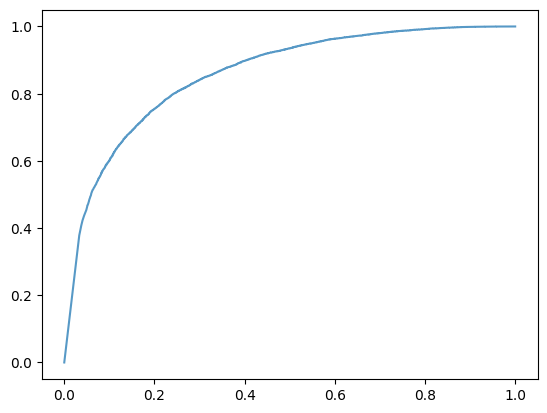

In [39]:
plt.plot(fpr, tpr, alpha=0.75 , label=f'Naive Bayes')


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# Assuming y_test contains your true labels
# and y_pred contains the hard predictions (0 or 1) from your model
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()


In [ ]:
import torch
from torch.nn import Sigmoid

# Assuming 'model' is your trained LSTM model
# and 'test_dataloader' is your DataLoader for test data
test_data = Dataset(test['text'], test['label'])
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)
model.eval()  # Set the model to evaluation mode

sigmoid = Sigmoid()
probabilities = []

with torch.no_grad():  # Disable gradient computation
    for inputs in test_dataloader:
        inputs = inputs.to(device)  # Ensure inputs are on the correct device
        outputs = model(inputs)  # Get model predictions (logits)

        # Apply sigmoid to convert logits to probabilities
        probs = sigmoid(outputs).squeeze()
        probabilities.extend(probs.cpu().numpy())

# 'probabilities' now contains the probability of being in the positive class


In [ ]:
# from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# test_data = ModifiedDataset(X_test, y_test)
# test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)
# # Set the model to evaluation mode
# model.eval()

# # Lists to store actual and predicted labels
# y_true = []
# y_pred = []

# with torch.no_grad():
#     for batch in test_dataloader:
#         inputs, target = batch
#         inputs = inputs.to(device)

#         outputs = model(inputs)
#         predictions = outputs.argmax(dim=1).cpu().numpy()  # Convert to numpy array
#         y_true.extend(target.cpu().numpy())
#         y_pred.extend(predictions)

# # Calculating the evaluation metrics
# conf_matrix = confusion_matrix(y_true, y_pred)
# accuracy = accuracy_score(y_true, y_pred)
# precision = precision_score(y_true, y_pred)
# recall = recall_score(y_true, y_pred)
# f1 = f1_score(y_true, y_pred)
# roc_auc = roc_auc_score(y_true, y_pred)

# # Extracting False Positives and False Negatives from the confusion matrix
# fp = conf_matrix[0][1]
# fn = conf_matrix[1][0]

# # Compiling the results
# results = {
#     "Confusion Matrix": conf_matrix,
#     "Accuracy": accuracy,
#     "Precision": precision,
#     "Recall": recall,
#     "F1 Score": f1,
#     "ROC AUC Score": roc_auc,
#     "False Positives (FP)": fp,
#     "False Negatives (FN)": fn
# }

# print(results)
